# Kaggle competition restaurant visitor forecasting competition
https://www.kaggle.com/c/recruit-restaurant-visitor-forecasting

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap, MDS
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import impute
import umap
from sklearn.ensemble import IsolationForest

# format notebook output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.core.display import display, HTML, Javascript
display(HTML("<style>.container { width:90% !important; }</style>"))

# style pandas display
pd.set_option('display.max_columns', None)

# matplotlib magic
%matplotlib inline

In [3]:
def desc(df):
    display(df.head())
    print(df.shape)
    print(df.dtypes)

# Load data

In [4]:
air_reserve = pd.read_csv('../../data_files/air_reserve.csv')
air_store_info = pd.read_csv('../../data_files/air_store_info.csv', encoding='utf-8')
air_visit_data = pd.read_csv('../../data_files/air_visit_data.csv')
date_info = pd.read_csv('../../data_files/date_info.csv')
hpg_reserve = pd.read_csv('../../data_files/hpg_reserve.csv')
hpg_store_info = pd.read_csv('../../data_files/hpg_store_info.csv')
sample_submission = pd.read_csv('../../data_files/sample_submission.csv')
store_id_relation = pd.read_csv('../../data_files/store_id_relation.csv')

## Merge data

In [5]:
air_reserve['reserve_date'] = air_reserve['reserve_datetime'].apply(lambda x: x[:10])
# air_reserve['reserve_date'] = pd.to_datetime(air_reserve['reserve_date'])

In [6]:
air_reserve['visit_date'] = air_reserve['visit_datetime'].apply(lambda x: x[:10])
# air_reserve['visit_date'] = pd.to_datetime(air_reserve['visit_date'])

In [7]:
air_reserve_daily = air_reserve[[
        'air_store_id',
        'visit_date',
        'reserve_visitors'
    ]].groupby(['air_store_id', 'visit_date'], as_index=False).agg('sum')

In [9]:
desc(air_reserve_daily)

,air_store_id,visit_date,reserve_visitors
0,air_00a91d42b08b08d9,2016-10-31,2
1,air_00a91d42b08b08d9,2016-12-05,9
2,air_00a91d42b08b08d9,2016-12-14,18
3,air_00a91d42b08b08d9,2016-12-17,2
4,air_00a91d42b08b08d9,2016-12-20,4


(29830, 3)
air_store_id        object
visit_date          object
reserve_visitors     int64
dtype: object


In [10]:
air_visit_data = pd.merge(
    left=air_visit_data,
    right=air_reserve_daily,
    on=['air_store_id', 'visit_date'],
    how='left',
    copy=False
)

In [13]:
# should we make a seperate column with binary for nullfill?
air_visit_data['reserve_visitors'].fillna(0, inplace=True)

In [14]:
desc(air_visit_data)

,air_store_id,visit_date,visitors,reserve_visitors
0,air_ba937bf13d40fb24,2016-01-13,25,0.0
1,air_ba937bf13d40fb24,2016-01-14,32,0.0
2,air_ba937bf13d40fb24,2016-01-15,29,0.0
3,air_ba937bf13d40fb24,2016-01-16,22,0.0
4,air_ba937bf13d40fb24,2016-01-18,6,0.0


(252108, 4)
air_store_id         object
visit_date           object
visitors              int64
reserve_visitors    float64
dtype: object


# Feature extraction with TSFRESH

In [15]:
extracted_features = extract_features(air_visit_data, column_id="air_store_id", column_sort="visit_date")

Feature Extraction: 100%|██████████| 20/20 [02:35<00:00,  7.78s/it]


In [16]:
extracted_features.shape

(829, 1588)

In [17]:
zero_variance_features = extracted_features.var().iloc[np.where(extracted_features.var() == 0)].index

In [18]:
len(zero_variance_features)

147

In [19]:
extracted_features = extracted_features[[col for col in extracted_features.columns if col not in zero_variance_features]]

In [20]:
extracted_features.shape

(829, 1441)

In [21]:
large_null_cols = extracted_features.columns[np.where(extracted_features.isnull().sum() >= 80)]

In [22]:
len(large_null_cols)

53

In [23]:
extracted_features = extracted_features[[col for col in extracted_features.columns if col not in large_null_cols]]

In [24]:
extracted_features.shape

(829, 1388)

In [25]:
extracted_features = impute(extracted_features)

In [26]:
extracted_features = pd.merge(
    left=extracted_features,
    right=air_store_info.set_index('air_store_id'),
    left_index=True,
    right_index=True,
    copy=False
)

In [27]:
genre_encoder = LabelEncoder()

extracted_features['air_genre_name'] = genre_encoder.fit_transform(extracted_features['air_genre_name'].values)

In [28]:
area_encoder = LabelEncoder()

extracted_features['air_area_name'] = genre_encoder.fit_transform(extracted_features['air_area_name'].values)

# Dimension reduction

## PCA

In [29]:
pca = PCA(n_components=2, random_state=42)

X = extracted_features.values
pca_reduced = pca.fit_transform(X)

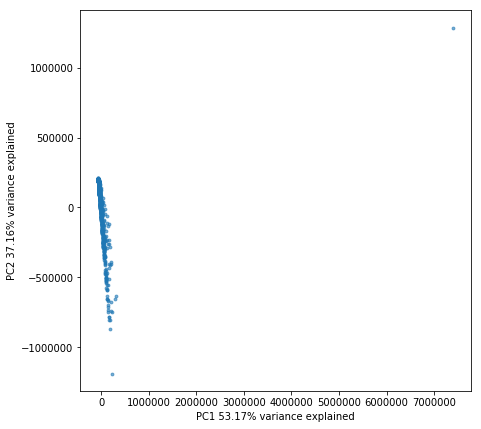

In [30]:
pc1_col = 'PC1 ' + '%.2f' % (pca.explained_variance_ratio_[0]*100) + '% variance explained'
pc2_col = 'PC2 ' + '%.2f' % (pca.explained_variance_ratio_[1]*100) + '% variance explained'

pd.DataFrame(pca_reduced).rename(columns={0: pc1_col, 1: pc2_col}).plot(
    kind='scatter',
    x=pc1_col,
    y=pc2_col,
    figsize=(7, 7),
    s=8,
    alpha=0.6
);

## UMAP

In [31]:
umap_embedding = umap.UMAP(n_neighbors=7,
                           min_dist=0.3,
                           metric='euclidean').fit_transform(extracted_features)

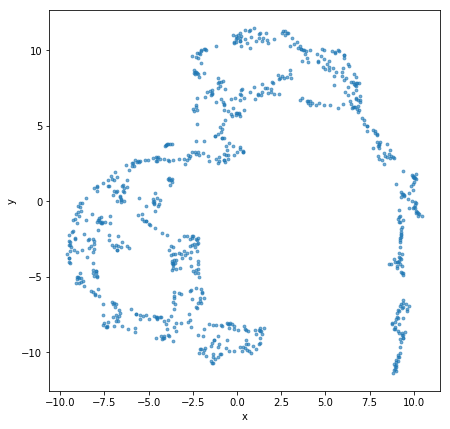

In [41]:
pd.DataFrame(umap_embedding).rename(columns={0: 'x', 1: 'y'}).plot(
    kind='scatter',
    x='x',
    y='y',
    figsize=(7,7),
    s=8,
    alpha=0.6
);

In [33]:
sil_scores = []

for k in range(2, 30):
    kmeans = KMeans(
        n_clusters=k,
        random_state=42
    );

    kmeans.fit(umap_embedding);
    
    sil_score = silhouette_score(umap_embedding, kmeans.predict(umap_embedding))
    
    sil_scores.append((k, sil_score))   

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=7, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=9, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=11, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=12, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=13, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=14, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=15, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=16, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=17, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=18, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=19, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=20, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=21, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=22, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=23, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=24, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=25, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=26, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=27, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=28, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=29, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

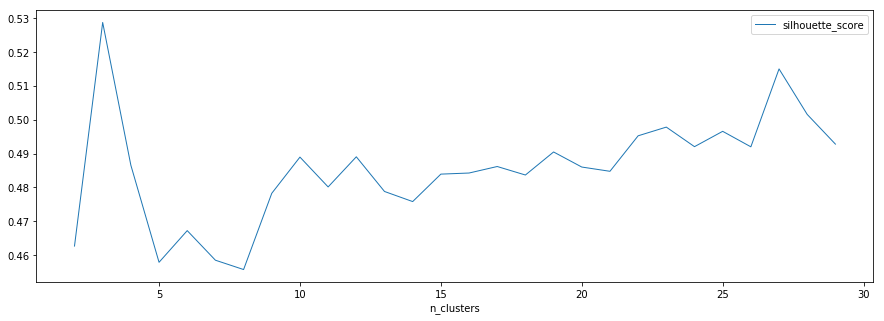

In [34]:
pd.DataFrame(sil_scores).rename(columns={0: 'n_clusters', 1: 'silhouette_score'}).plot(
    kind='line',
    lw=1,
    x='n_clusters',
    figsize=(15, 5)
);

In [35]:
pd.DataFrame(sil_scores).rename(columns={0: 'n_clusters', 1: 'silhouette_score'}).sort_values('silhouette_score', ascending=False).head(2)

,n_clusters,silhouette_score
1,3,0.528737
25,27,0.515006


So choose `n_clusters == 3`

In [36]:
kmeans = KMeans(n_clusters=3, random_state=42)

clusters = kmeans.fit_predict(umap_embedding)

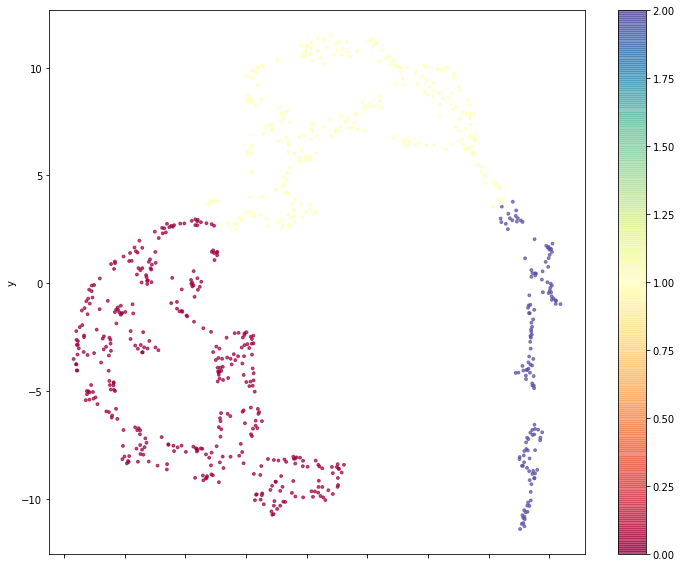

In [37]:
pd.DataFrame(umap_embedding).rename(columns={0: 'x', 1: 'y'}).plot(
    kind='scatter',
    x='x',
    y='y',
    figsize=(12,10),
    s=8,
    alpha=0.7,
    c=clusters,
    cmap='Spectral'
);

In [38]:
gm = GaussianMixture(
    n_components=3,
    covariance_type='full',
    random_state=42
)

X = umap_embedding
gm.fit(X)

clusters = gm.predict(X)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=3, n_init=1, precisions_init=None,
        random_state=42, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

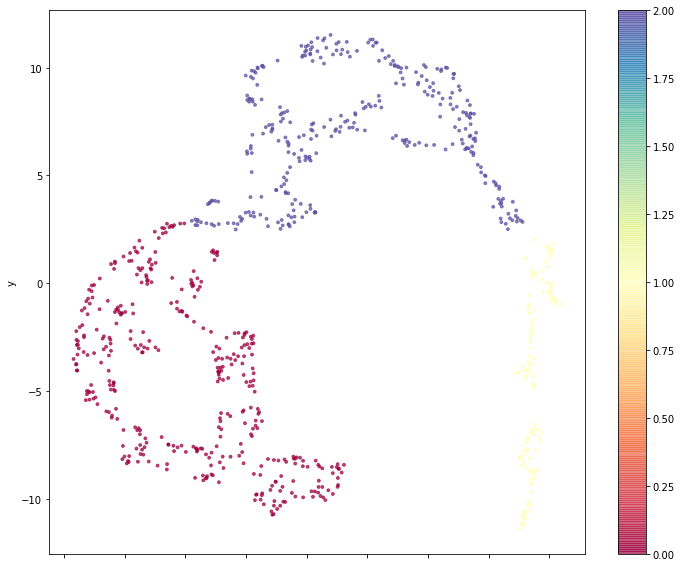

In [39]:
pd.DataFrame(umap_embedding).rename(columns={0: 'x', 1: 'y'}).plot(
    kind='scatter',
    x='x',
    y='y',
    figsize=(12,10),
    s=8,
    alpha=0.7,
    c=clusters,
    cmap='Spectral'
);

## TSNE

In [40]:
tsne = TSNE(n_components=2, random_state=42, perplexity=10, metric='euclidean')


X = extracted_features.values
tsne_embedded = tsne.fit_transform(X)

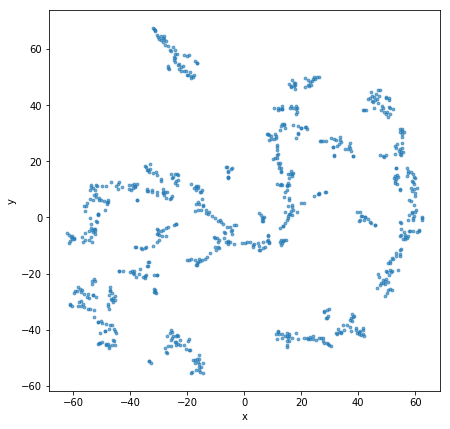

In [42]:
pd.DataFrame(tsne_embedded).rename(columns={0: 'x', 1: 'y'}).plot(
    kind='scatter',
    x='x',
    y='y',
    figsize=(7, 7),
    s=8,
    alpha=0.6
);

In [43]:
sil_scores = []

for k in range(2, 30):
    kmeans = KMeans(
        n_clusters=k,
        random_state=42
    );

    kmeans.fit(tsne_embedded);
    
    sil_score = silhouette_score(tsne_embedded, kmeans.predict(tsne_embedded))
    
    sil_scores.append((k, sil_score))   

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=7, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=9, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=11, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=12, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=13, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=14, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=15, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=16, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=17, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=18, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=19, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=20, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=21, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=22, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=23, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=24, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=25, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=26, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=27, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=28, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=29, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

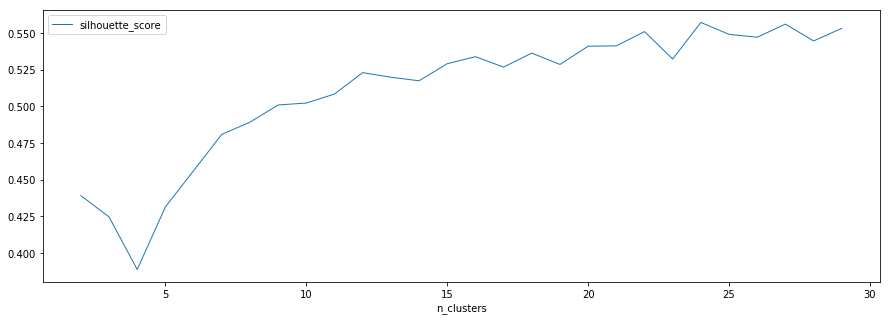

In [44]:
pd.DataFrame(sil_scores).rename(columns={0: 'n_clusters', 1: 'silhouette_score'}).plot(
    kind='line',
    lw=1,
    x='n_clusters',
    figsize=(15, 5)
);

In [46]:
pd.DataFrame(sil_scores).rename(columns={0: 'n_clusters', 1: 'silhouette_score'}).sort_values('silhouette_score', ascending=False).head(5)

,n_clusters,silhouette_score
22,24,0.557152
25,27,0.556036
27,29,0.553142
20,22,0.550919
23,25,0.549035


Choose `n_clusters == 24`

In [47]:
kmeans = KMeans(n_clusters=24, random_state=42)

clusters = kmeans.fit_predict(tsne_embedded)

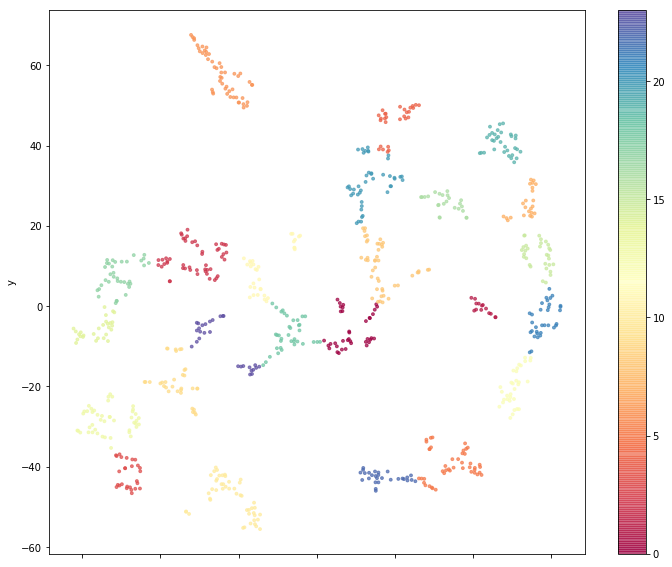

In [48]:
pd.DataFrame(tsne_embedded).rename(columns={0: 'x', 1: 'y'}).plot(
    kind='scatter',
    x='x',
    y='y',
    figsize=(12,10),
    s=8,
    alpha=0.7,
    c=clusters,
    cmap='Spectral'
);

In [49]:
gm = GaussianMixture(
    n_components=24,
    covariance_type='full',
    random_state=42
)

X = tsne_embedded
gm.fit(X)

clusters = gm.predict(X)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=24, n_init=1, precisions_init=None,
        random_state=42, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

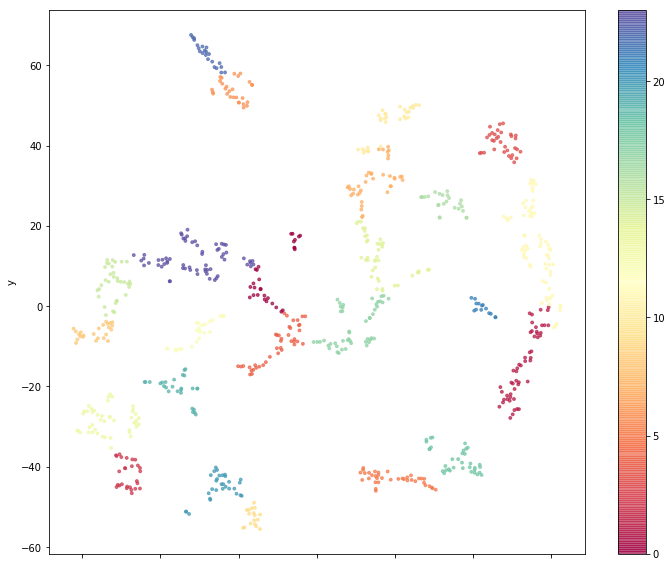

In [50]:
pd.DataFrame(tsne_embedded).rename(columns={0: 'x', 1: 'y'}).plot(
    kind='scatter',
    x='x',
    y='y',
    figsize=(12,10),
    s=8,
    alpha=0.7,
    c=clusters,
    cmap='Spectral'
);

# Outlier detection

## Isolation Forests

Should the outliers be detected in reduced dimensions, or original space?

In [52]:
isof = IsolationForest(
    n_estimators=100,
    contamination=0.05,
    max_features=1.0,
    random_state=42
)

X = extracted_features.values

isof.fit(X)

IsolationForest(bootstrap=False, contamination=0.05, max_features=1.0,
        max_samples='auto', n_estimators=100, n_jobs=1, random_state=42,
        verbose=0)

In [53]:
isof_outliers = isof.predict(X)

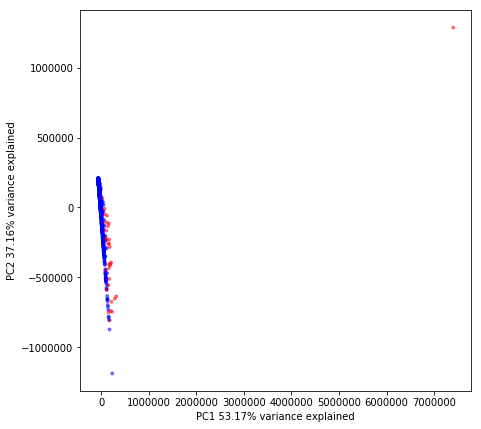

In [54]:
pc1_col = 'PC1 ' + '%.2f' % (pca.explained_variance_ratio_[0]*100) + '% variance explained'
pc2_col = 'PC2 ' + '%.2f' % (pca.explained_variance_ratio_[1]*100) + '% variance explained'

pd.DataFrame(pca_reduced).rename(columns={0: pc1_col, 1: pc2_col}).plot(
    kind='scatter',
    x=pc1_col,
    y=pc2_col,
    figsize=(7, 7),
    s=8,
    alpha=0.5,
    c=['red' if x == -1 else 'blue' for x in isof_outliers]
);

In [58]:
pd.DataFrame(pca_reduced).sort_values(0, ascending=False)

,0,1
752,7.402993e+06,1.286677e+06
7,3.186973e+05,-6.360472e+05
743,2.870735e+05,-6.526505e+05
71,2.328072e+05,-1.187899e+06
721,2.285098e+05,-7.467781e+05
540,2.148825e+05,-6.743535e+05
179,2.073670e+05,-3.934247e+05
371,1.994176e+05,-7.405633e+05
401,1.989487e+05,-4.041718e+05
578,1.820199e+05,-4.142915e+05


In [60]:
extracted_features.iloc[[752]]

,reserve_visitors__abs_energy,reserve_visitors__absolute_sum_of_changes,"reserve_visitors__agg_autocorrelation__f_agg_""mean""","reserve_visitors__agg_autocorrelation__f_agg_""median""","reserve_visitors__agg_autocorrelation__f_agg_""var""","reserve_visitors__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""intercept""","reserve_visitors__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""rvalue""","reserve_visitors__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""slope""","reserve_visitors__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""stderr""","reserve_visitors__agg_linear_trend__f_agg_""max""__chunk_len_50__attr_""intercept""","reserve_visitors__agg_linear_trend__f_agg_""max""__chunk_len_50__attr_""rvalue""","reserve_visitors__agg_linear_trend__f_agg_""max""__chunk_len_50__attr_""slope""","reserve_visitors__agg_linear_trend__f_agg_""max""__chunk_len_50__attr_""stderr""","reserve_visitors__agg_linear_trend__f_agg_""max""__chunk_len_5__attr_""intercept""","reserve_visitors__agg_linear_trend__f_agg_""max""__chunk_len_5__attr_""rvalue""","reserve_visitors__agg_linear_trend__f_agg_""max""__chunk_len_5__attr_""slope""","reserve_visitors__agg_linear_trend__f_agg_""max""__chunk_len_5__attr_""stderr""","reserve_visitors__agg_linear_trend__f_agg_""mean""__chunk_len_10__attr_""intercept""","reserve_visitors__agg_linear_trend__f_agg_""mean""__chunk_len_10__attr_""rvalue""","reserve_visitors__agg_linear_trend__f_agg_""mean""__chunk_len_10__attr_""slope""","reserve_visitors__agg_linear_trend__f_agg_""mean""__chunk_len_10__attr_""stderr""","reserve_visitors__agg_linear_trend__f_agg_""mean""__chunk_len_50__attr_""intercept""","reserve_visitors__agg_linear_trend__f_agg_""mean""__chunk_len_50__attr_""rvalue""","reserve_visitors__agg_linear_trend__f_agg_""mean""__chunk_len_50__attr_""slope""","reserve_visitors__agg_linear_trend__f_agg_""mean""__chunk_len_50__attr_""stderr""","reserve_visitors__agg_linear_trend__f_agg_""mean""__chunk_len_5__attr_""intercept""","reserve_visitors__agg_linear_trend__f_agg_""mean""__chunk_len_5__attr_""rvalue""","reserve_visitors__agg_linear_trend__f_agg_""mean""__chunk_len_5__attr_""slope""","reserve_visitors__agg_linear_trend__f_agg_""mean""__chunk_len_5__attr_""stderr""","reserve_visitors__agg_linear_trend__f_agg_""min""__chunk_len_10__attr_""intercept""","reserve_visitors__agg_linear_trend__f_agg_""min""__chunk_len_10__attr_""rvalue""","reserve_visitors__agg_linear_trend__f_agg_""min""__chunk_len_10__attr_""slope""","reserve_visitors__agg_linear_trend__f_agg_""min""__chunk_len_10__attr_""stderr""","reserve_visitors__agg_linear_trend__f_agg_""min""__chunk_len_50__attr_""intercept""","reserve_visitors__agg_linear_trend__f_agg_""min""__chunk_len_50__attr_""rvalue""","reserve_visitors__agg_linear_trend__f_agg_""min""__chunk_len_50__attr_""slope""","reserve_visitors__agg_linear_trend__f_agg_""min""__chunk_len_50__attr_""stderr""","reserve_visitors__agg_linear_trend__f_agg_""min""__chunk_len_5__attr_""intercept""","reserve_visitors__agg_linear_trend__f_agg_""min""__chunk_len_5__attr_""rvalue""","reserve_visitors__agg_linear_trend__f_agg_""min""__chunk_len_5__attr_""slope""","reserve_visitors__agg_linear_trend__f_agg_""min""__chunk_len_5__attr_""stderr""","reserve_visitors__agg_linear_trend__f_agg_""var""__chunk_len_10__attr_""intercept""","reserve_visitors__agg_linear_trend__f_agg_""var""__chunk_len_10__attr_""rvalue""","reserve_visitors__agg_linear_trend__f_agg_""var""__chunk_len_10__attr_""slope""","reserve_visitors__agg_linear_trend__f_agg_""var""__chunk_len_10__attr_""stderr""","reserve_visitors__agg_linear_trend__f_agg_""var""__chunk_len_50__attr_""intercept""","reserve_visitors__agg_linear_trend__f_agg_""var""__chunk_len_50__attr_""rvalue""","reserve_visitors__agg_linear_trend__f_agg_""var""__chunk_len_50__attr_""slope""","reserve_visitors__agg_linear_trend__f_agg_""var""__chunk_len_50__attr_""stderr""","reserve_visitors__agg_linear_trend__f_agg_""var""__chunk_len_5__attr_""intercept""",

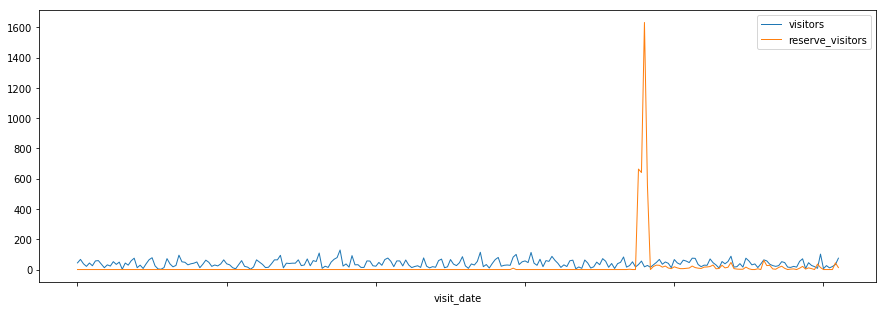

In [70]:
air_visit_data[air_visit_data['air_store_id'] == 'air_e7fbee4e3cfe65c5'][[
    'visit_date',
    'visitors',
    'reserve_visitors'
]].plot(
    kind='line',
    lw=1,
    figsize=(15, 5),
    x='visit_date'
);

In [71]:
air_visit_data[air_visit_data['air_store_id'] == 'air_e7fbee4e3cfe65c5'].sort_values('reserve_visitors', ascending=False)

,air_store_id,visit_date,visitors,reserve_visitors
17043,air_e7fbee4e3cfe65c5,2017-02-05,18,1633.0
17041,air_e7fbee4e3cfe65c5,2017-02-03,33,664.0
17042,air_e7fbee4e3cfe65c5,2017-02-04,56,641.0
17044,air_e7fbee4e3cfe65c5,2017-02-07,27,557.0
17083,air_e7fbee4e3cfe65c5,2017-03-24,64,61.0
17072,air_e7fbee4e3cfe65c5,2017-03-11,88,47.0
17107,air_e7fbee4e3cfe65c5,2017-04-21,33,44.0
17101,air_e7fbee4e3cfe65c5,2017-04-14,8,36.0
17066,air_e7fbee4e3cfe65c5,2017-03-04,45,30.0
17047,air_e7fbee4e3cfe65c5,2017-02-10,47,29.0


In [73]:
air_visit_data[
    air_visit_data['reserve_visitors'] > air_visit_data['visitors']
].sort_values('reserve_visitors', ascending=False)

,air_store_id,visit_date,visitors,reserve_visitors
17043,air_e7fbee4e3cfe65c5,2017-02-05,18,1633.0
17041,air_e7fbee4e3cfe65c5,2017-02-03,33,664.0
17042,air_e7fbee4e3cfe65c5,2017-02-04,56,641.0
17044,air_e7fbee4e3cfe65c5,2017-02-07,27,557.0
68051,air_465bddfed3353b23,2017-01-09,30,466.0
20993,air_b23d0f519291247d,2016-12-16,117,155.0
108738,air_a17f0778617c76e2,2017-03-16,17,142.0
71565,air_b439391e72899756,2017-02-23,11,104.0
154942,air_56cebcbd6906e04c,2017-03-19,67,104.0
180433,air_a083834e7ffe187e,2016-12-22,66,99.0


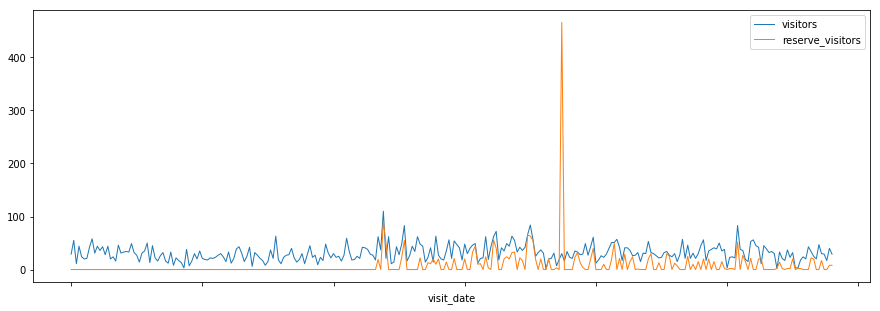

In [74]:
air_visit_data[air_visit_data['air_store_id'] == 'air_465bddfed3353b23'][[
    'visit_date',
    'visitors',
    'reserve_visitors'
]].plot(
    kind='line',
    lw=1,
    figsize=(15, 5),
    x='visit_date'
);

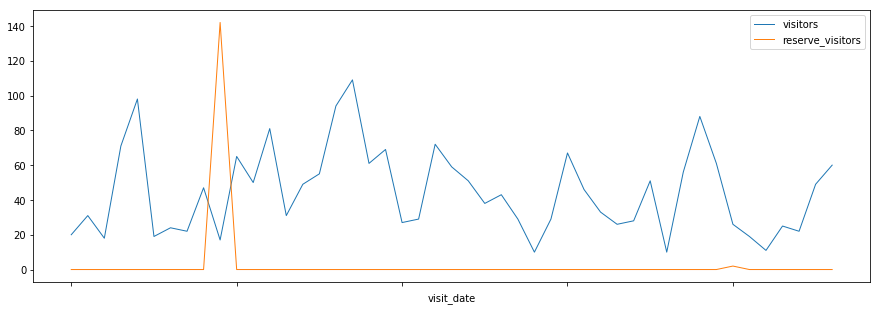

In [75]:
air_visit_data[air_visit_data['air_store_id'] == 'air_a17f0778617c76e2'][[
    'visit_date',
    'visitors',
    'reserve_visitors'
]].plot(
    kind='line',
    lw=1,
    figsize=(15, 5),
    x='visit_date'
);

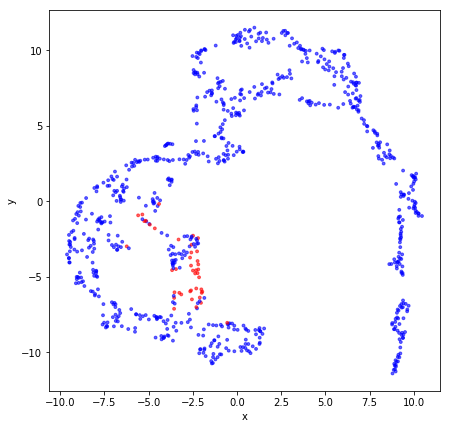

In [55]:
pd.DataFrame(umap_embedding).rename(columns={0: 'x', 1: 'y'}).plot(
    kind='scatter',
    x='x',
    y='y',
    figsize=(7,7),
    s=8,
    alpha=0.6,
    c=['red' if x == -1 else 'blue' for x in isof_outliers]
);

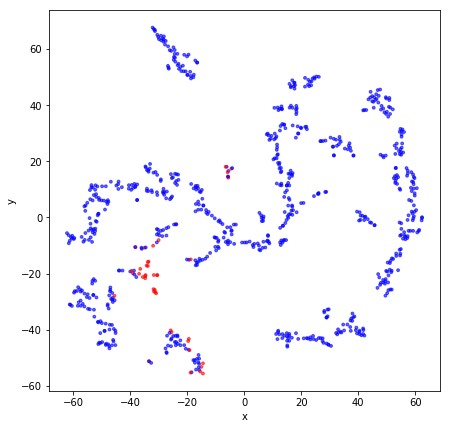

In [56]:
pd.DataFrame(tsne_embedded).rename(columns={0: 'x', 1: 'y'}).plot(
    kind='scatter',
    x='x',
    y='y',
    figsize=(7, 7),
    s=8,
    alpha=0.6,
    c=['red' if x == -1 else 'blue' for x in isof_outliers]
);